# ***Section Clinical State Binary Classification***

This notebook shows the process of classification section samples into binary clinical state (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [10]:
# Define folder that contains the dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dataset
DATA_IN_PATH = f"{DHG_PATH}/Preprocessed"
# Define file that contains clinical state annotations
CLINICAL_STATE_ANNOTATIONS_PATH = f"{DHG_PATH}/Clinical_state_annotations.csv"
# Define folder to save classification models for later use
MODELS_PATH = "C:/Users/Leor/Desktop/Thesis/section_classification_models"
# Classification model number of epochs
EPHOCS = 100
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 44000
# The MSI sample type for filtering
SAMPLE_TYPE = "s"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150
# Treshould standard deviation for Gaussian kernel
TRESH_GAUSSIAN_SIGMA = 0.5

### ***Reading MSI clinical state anotations***

Next, let's read the clinical state anotations for each MSI:

In [3]:
# Read clinical state annotations csv
clinical_state_df = pd.read_csv(CLINICAL_STATE_ANNOTATIONS_PATH)

# Filter by sample_type
clinical_state_df = clinical_state_df[clinical_state_df["sample_type"] ==
                                      SAMPLE_TYPE]

### ***Get all spectra's from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all MSI:

In [4]:
# Create lists to store each spectra's info
file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []
is_tissue = []

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DATA_IN_PATH,
                                f"{msi_row.file_name}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Keep sample file name of spectra
      file_names.append(msi_row.file_name)
      # Keep sample number of spectra
      sample_numbers.append(msi_row.sample_number)
      # Keep sample histology of spectra
      histologies.append(msi_row.histology)
      # Keep sample who grade of spectra
      who_grades.append(msi_row.who_grade)
      # Keep x coordinate of spectra
      x_coordinates.append(x)
      # Keep y coordinate of spectra
      y_coordinates.append(y)
      # Keep  of spectra
      idxs.append(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep boolean indication on if spectra is tissue
        is_tissue.append(True)
      else:
        # Keep boolean indication on if spectra is not tissue
        is_tissue.append(False)
        
# Convert to numpy array
file_names = np.array(file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
is_tissue = np.array(is_tissue)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [02:13<00:00,  5.55s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [5]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DATA_IN_PATH, f"{file_name}.imzML"))
    for file_name in clinical_state_df.file_name.unique()
}

In [6]:
mzs, _ =  parsers["HG 10-s"].getspectrum(0)
mzs_filter = (mzs >= 50) & (mzs < 600)

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [7]:
def map_index(index: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding index from the EagerTensor object
  index = index.numpy()
  # Reading spectra from parser
  file_name = file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Return spectra and label
  return (spectra[mzs_filter], labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(indexes: np.ndarray, batch_size: int) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(lambda i: tf.py_function(
      func=map_index, inp=[i], Tout=[tf.float32, tf.float32]))
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [8]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(512),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***Leave one sample out classification:***

Next, let"s create a classification model for each leave one sample out option:

In [11]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data - does not include the excluded sample
  # and only include tissue spectra's
  train_filter = ((sample_numbers != exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(train_indexes,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=labels[train_filter])

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE)
  validation_generator = create_ds(val_indexes, BATCH_SIZE)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor="val_binary_accuracy",
      mode="max",
      save_best_only=True)

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              verbose=1,
                                              patience=5,
                                              min_delta=0.0001)

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(optimizer,
                               loss=losses.BinaryCrossentropy(),
                               metrics=["binary_accuracy"])

  # Train the classification model
  history = classification_model.fit(
      x=train_generator,
      validation_data=validation_generator,
      epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback])

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evalute on train and validation
  train_metrics[exclude_sample] = classification_model.evaluate(
      x=train_generator)
  validation_metrics[exclude_sample] = classification_model.evaluate(
      x=validation_generator)

  # Clean model for next iteration
  classification_model = None

  # Separate training 
  print("#" * 30)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/100
84/84 [==============================] - 21s 231ms/step - loss: 0.1314 - binary_accuracy: 0.9516 - val_loss: 0.6929 - val_binary_accuracy: 0.6517
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 2/100
84/84 [==============================] - 20s 237ms/step - loss: 0.0255 - binary_accuracy: 0.9918 - val_loss: 0.8345 - val_binary_accuracy: 0.6517
Epoch 3/100
84/84 [==============================] - 19s 231ms/step - loss: 0.0192 - binary_accuracy: 0.9940 - val_loss: 0.7618 - val_binary_accuracy: 0.6517
Epoch 4/100
84/84 [==============================] - 20s 234ms/step - loss: 0.0138 - binary_accuracy: 0.9949 - val_loss: 0.5741 - val_binary_accuracy: 0.6517
Epoch 5/100
84/84 [==============================] - 20s 236ms/step - loss: 0.0093 - binary_accuracy: 0.9964 - val_loss: 0.4779 - val_binary_accuracy: 0.6752
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excl

  5%|▍         | 1/22 [06:19<2:12:44, 379.26s/it]

##############################
Epoch 1/100
83/83 [==============================] - 21s 243ms/step - loss: 0.1784 - binary_accuracy: 0.9310 - val_loss: 0.7042 - val_binary_accuracy: 0.6225
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 2/100
83/83 [==============================] - 20s 242ms/step - loss: 0.0326 - binary_accuracy: 0.9889 - val_loss: 0.7655 - val_binary_accuracy: 0.6225
Epoch 3/100
83/83 [==============================] - 21s 250ms/step - loss: 0.0235 - binary_accuracy: 0.9920 - val_loss: 0.7720 - val_binary_accuracy: 0.6225
Epoch 4/100
83/83 [==============================] - 20s 236ms/step - loss: 0.0157 - binary_accuracy: 0.9944 - val_loss: 0.6075 - val_binary_accuracy: 0.6225
Epoch 5/100
83/83 [==============================] - 21s 251ms/step - loss: 0.0104 - binary_accuracy: 0.9966 - val_loss: 0.3835 - val_binary_accuracy: 0.7556
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/sec

  9%|▉         | 2/22 [12:20<2:02:50, 368.54s/it]

##############################
Epoch 1/100
83/83 [==============================] - 22s 255ms/step - loss: 0.1838 - binary_accuracy: 0.9277 - val_loss: 0.6718 - val_binary_accuracy: 0.6243
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 2/100
83/83 [==============================] - 21s 250ms/step - loss: 0.0335 - binary_accuracy: 0.9888 - val_loss: 0.6631 - val_binary_accuracy: 0.6243
Epoch 3/100
83/83 [==============================] - 21s 249ms/step - loss: 0.0204 - binary_accuracy: 0.9928 - val_loss: 0.6030 - val_binary_accuracy: 0.6243
Epoch 4/100
83/83 [==============================] - 20s 236ms/step - loss: 0.0139 - binary_accuracy: 0.9957 - val_loss: 0.5023 - val_binary_accuracy: 0.9396
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 5/100
83/83 [==============================] - 19s 232ms/step - loss: 0.0137 - binary_accuracy: 0.9951 - va

 14%|█▎        | 3/22 [19:46<2:08:00, 404.21s/it]

##############################
Epoch 1/100
84/84 [==============================] - 22s 255ms/step - loss: 0.1896 - binary_accuracy: 0.9274 - val_loss: 0.6812 - val_binary_accuracy: 0.6286
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 2/100
84/84 [==============================] - 20s 240ms/step - loss: 0.0362 - binary_accuracy: 0.9875 - val_loss: 0.6843 - val_binary_accuracy: 0.6286
Epoch 3/100
84/84 [==============================] - 21s 246ms/step - loss: 0.0194 - binary_accuracy: 0.9933 - val_loss: 0.6340 - val_binary_accuracy: 0.6286
Epoch 4/100
84/84 [==============================] - 21s 248ms/step - loss: 0.0148 - binary_accuracy: 0.9951 - val_loss: 0.5558 - val_binary_accuracy: 0.6290
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 5/100
84/84 [==============================] - 20s 238ms/step - loss: 0.0125 - binary_accuracy: 0.9959 - va

 18%|█▊        | 4/22 [26:35<2:01:47, 405.99s/it]

##############################
Epoch 1/100
84/84 [==============================] - 22s 255ms/step - loss: 0.1777 - binary_accuracy: 0.9317 - val_loss: 0.6753 - val_binary_accuracy: 0.6274
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 2/100
84/84 [==============================] - 21s 252ms/step - loss: 0.0339 - binary_accuracy: 0.9880 - val_loss: 0.6510 - val_binary_accuracy: 0.6274
Epoch 3/100
84/84 [==============================] - 21s 248ms/step - loss: 0.0239 - binary_accuracy: 0.9916 - val_loss: 0.6234 - val_binary_accuracy: 0.6274
Epoch 4/100
84/84 [==============================] - 21s 252ms/step - loss: 0.0167 - binary_accuracy: 0.9942 - val_loss: 0.4970 - val_binary_accuracy: 0.7812
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 5/100
84/84 [==============================] - 20s 242ms/step - loss: 0.0100 - binary_accuracy: 0.9964 - va

 23%|██▎       | 5/22 [32:06<1:47:20, 378.84s/it]

##############################
Epoch 1/100
84/84 [==============================] - 20s 234ms/step - loss: 0.1853 - binary_accuracy: 0.9271 - val_loss: 0.7181 - val_binary_accuracy: 0.6271
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 2/100
84/84 [==============================] - 20s 237ms/step - loss: 0.0325 - binary_accuracy: 0.9890 - val_loss: 0.7629 - val_binary_accuracy: 0.6271
Epoch 3/100
84/84 [==============================] - 21s 253ms/step - loss: 0.0197 - binary_accuracy: 0.9937 - val_loss: 0.7235 - val_binary_accuracy: 0.6271
Epoch 4/100
84/84 [==============================] - 21s 247ms/step - loss: 0.0147 - binary_accuracy: 0.9946 - val_loss: 0.6850 - val_binary_accuracy: 0.6271
Epoch 5/100
84/84 [==============================] - 20s 245ms/step - loss: 0.0126 - binary_accuracy: 0.9960 - val_loss: 0.4258 - val_binary_accuracy: 0.6852
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/sec

 27%|██▋       | 6/22 [38:34<1:41:50, 381.93s/it]

##############################
Epoch 1/100
79/79 [==============================] - 20s 249ms/step - loss: 0.1835 - binary_accuracy: 0.9296 - val_loss: 0.7136 - val_binary_accuracy: 0.6054
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 2/100
79/79 [==============================] - 19s 245ms/step - loss: 0.0334 - binary_accuracy: 0.9887 - val_loss: 0.7749 - val_binary_accuracy: 0.6054
Epoch 3/100
79/79 [==============================] - 19s 244ms/step - loss: 0.0175 - binary_accuracy: 0.9940 - val_loss: 0.7633 - val_binary_accuracy: 0.6054
Epoch 4/100
79/79 [==============================] - 19s 243ms/step - loss: 0.0166 - binary_accuracy: 0.9942 - val_loss: 0.5855 - val_binary_accuracy: 0.6054
Epoch 5/100
79/79 [==============================] - 19s 240ms/step - loss: 0.0118 - binary_accuracy: 0.9962 - val_loss: 0.4120 - val_binary_accuracy: 0.6949
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/sec

 32%|███▏      | 7/22 [44:43<1:34:28, 377.88s/it]

##############################
Epoch 1/100
84/84 [==============================] - 21s 237ms/step - loss: 0.1762 - binary_accuracy: 0.9326 - val_loss: 0.6903 - val_binary_accuracy: 0.6272
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 2/100
84/84 [==============================] - 21s 255ms/step - loss: 0.0384 - binary_accuracy: 0.9865 - val_loss: 0.7018 - val_binary_accuracy: 0.6272
Epoch 3/100
84/84 [==============================] - 23s 272ms/step - loss: 0.0203 - binary_accuracy: 0.9925 - val_loss: 0.6689 - val_binary_accuracy: 0.6272
Epoch 4/100
84/84 [==============================] - 23s 273ms/step - loss: 0.0161 - binary_accuracy: 0.9947 - val_loss: 0.5829 - val_binary_accuracy: 0.6272
Epoch 5/100
84/84 [==============================] - 24s 285ms/step - loss: 0.0121 - binary_accuracy: 0.9959 - val_loss: 0.3732 - val_binary_accuracy: 0.7784
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/sec

 36%|███▋      | 8/22 [53:31<1:39:18, 425.61s/it]

##############################
Epoch 1/100
83/83 [==============================] - 23s 272ms/step - loss: 0.1772 - binary_accuracy: 0.9302 - val_loss: 0.6842 - val_binary_accuracy: 0.6233
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 2/100
83/83 [==============================] - 22s 260ms/step - loss: 0.0357 - binary_accuracy: 0.9878 - val_loss: 0.7157 - val_binary_accuracy: 0.6233
Epoch 3/100
83/83 [==============================] - 22s 270ms/step - loss: 0.0195 - binary_accuracy: 0.9929 - val_loss: 0.6394 - val_binary_accuracy: 0.6233
Epoch 4/100
83/83 [==============================] - 22s 264ms/step - loss: 0.0157 - binary_accuracy: 0.9946 - val_loss: 0.5338 - val_binary_accuracy: 0.6292
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 5/100
83/83 [==============================] - 21s 259ms/step - loss: 0.0140 - binary_accuracy: 0.9956 - 

 41%|████      | 9/22 [1:00:13<1:30:35, 418.11s/it]

##############################
Epoch 1/100
80/80 [==============================] - 23s 282ms/step - loss: 0.1875 - binary_accuracy: 0.9267 - val_loss: 0.6697 - val_binary_accuracy: 0.6113
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 2/100
80/80 [==============================] - 23s 289ms/step - loss: 0.0383 - binary_accuracy: 0.9864 - val_loss: 0.6499 - val_binary_accuracy: 0.6113
Epoch 3/100
80/80 [==============================] - 22s 275ms/step - loss: 0.0206 - binary_accuracy: 0.9929 - val_loss: 0.6243 - val_binary_accuracy: 0.6113
Epoch 4/100
80/80 [==============================] - 23s 286ms/step - loss: 0.0178 - binary_accuracy: 0.9939 - val_loss: 0.5490 - val_binary_accuracy: 0.9142
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 5/100
80/80 [==============================] - 22s 269ms/step - loss: 0.0119 - binary_accuracy: 0.9962 - 

 45%|████▌     | 10/22 [1:06:24<1:20:45, 403.77s/it]

##############################
Epoch 1/100
78/78 [==============================] - 21s 265ms/step - loss: 0.1983 - binary_accuracy: 0.9229 - val_loss: 0.6849 - val_binary_accuracy: 0.5967
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 2/100
78/78 [==============================] - 20s 253ms/step - loss: 0.0401 - binary_accuracy: 0.9858 - val_loss: 0.6761 - val_binary_accuracy: 0.5967
Epoch 3/100
78/78 [==============================] - 21s 275ms/step - loss: 0.0271 - binary_accuracy: 0.9909 - val_loss: 0.6176 - val_binary_accuracy: 0.5967
Epoch 4/100
78/78 [==============================] - 22s 278ms/step - loss: 0.0123 - binary_accuracy: 0.9956 - val_loss: 0.5412 - val_binary_accuracy: 0.9660
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 5/100
78/78 [==============================] - 20s 257ms/step - loss: 0.0100 - binary_accuracy: 0.9971 - 

 50%|█████     | 11/22 [1:12:54<1:13:12, 399.30s/it]

##############################
Epoch 1/100
82/82 [==============================] - 22s 258ms/step - loss: 0.1972 - binary_accuracy: 0.9252 - val_loss: 0.6800 - val_binary_accuracy: 0.6191
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 2/100
82/82 [==============================] - 22s 269ms/step - loss: 0.0394 - binary_accuracy: 0.9854 - val_loss: 0.7015 - val_binary_accuracy: 0.6191
Epoch 3/100
82/82 [==============================] - 24s 290ms/step - loss: 0.0213 - binary_accuracy: 0.9926 - val_loss: 0.6760 - val_binary_accuracy: 0.6191
Epoch 4/100
82/82 [==============================] - 22s 268ms/step - loss: 0.0136 - binary_accuracy: 0.9951 - val_loss: 0.5803 - val_binary_accuracy: 0.6191
Epoch 5/100
82/82 [==============================] - 23s 276ms/step - loss: 0.0109 - binary_accuracy: 0.9961 - val_loss: 0.3174 - val_binary_accuracy: 0.9261
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 55%|█████▍    | 12/22 [1:21:24<1:12:09, 432.98s/it]

##############################
Epoch 1/100
80/80 [==============================] - 21s 257ms/step - loss: 0.1944 - binary_accuracy: 0.9235 - val_loss: 0.6874 - val_binary_accuracy: 0.6078
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 2/100
80/80 [==============================] - 21s 258ms/step - loss: 0.0401 - binary_accuracy: 0.9848 - val_loss: 0.7023 - val_binary_accuracy: 0.6078
Epoch 3/100
80/80 [==============================] - 21s 267ms/step - loss: 0.0194 - binary_accuracy: 0.9931 - val_loss: 0.6590 - val_binary_accuracy: 0.6078
Epoch 4/100
80/80 [==============================] - 22s 271ms/step - loss: 0.0109 - binary_accuracy: 0.9960 - val_loss: 0.5319 - val_binary_accuracy: 0.6190
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 5/100
80/80 [==============================] - 21s 261ms/step - loss: 0.0170 - binary_accuracy: 0.9943 - 

 59%|█████▉    | 13/22 [1:31:46<1:13:34, 490.47s/it]

##############################
Epoch 1/100
82/82 [==============================] - 22s 263ms/step - loss: 0.1613 - binary_accuracy: 0.9396 - val_loss: 0.6816 - val_binary_accuracy: 0.6195
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 2/100
82/82 [==============================] - 23s 273ms/step - loss: 0.0219 - binary_accuracy: 0.9931 - val_loss: 0.7398 - val_binary_accuracy: 0.6195
Epoch 3/100
82/82 [==============================] - 22s 265ms/step - loss: 0.0143 - binary_accuracy: 0.9956 - val_loss: 0.7726 - val_binary_accuracy: 0.6195
Epoch 4/100
82/82 [==============================] - 22s 272ms/step - loss: 0.0092 - binary_accuracy: 0.9967 - val_loss: 0.6368 - val_binary_accuracy: 0.6195
Epoch 5/100
82/82 [==============================] - 22s 271ms/step - loss: 0.0082 - binary_accuracy: 0.9975 - val_loss: 0.4416 - val_binary_accuracy: 0.6865
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 64%|██████▎   | 14/22 [1:39:35<1:04:30, 483.85s/it]

##############################
Epoch 1/100
82/82 [==============================] - 23s 269ms/step - loss: 0.1996 - binary_accuracy: 0.9224 - val_loss: 0.6781 - val_binary_accuracy: 0.6675
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 2/100
82/82 [==============================] - 23s 281ms/step - loss: 0.0377 - binary_accuracy: 0.9870 - val_loss: 0.7366 - val_binary_accuracy: 0.6675
Epoch 3/100
82/82 [==============================] - 23s 274ms/step - loss: 0.0211 - binary_accuracy: 0.9935 - val_loss: 0.7351 - val_binary_accuracy: 0.6675
Epoch 4/100
82/82 [==============================] - 22s 270ms/step - loss: 0.0158 - binary_accuracy: 0.9948 - val_loss: 0.6210 - val_binary_accuracy: 0.6675
Epoch 5/100
82/82 [==============================] - 23s 276ms/step - loss: 0.0132 - binary_accuracy: 0.9950 - val_loss: 0.5288 - val_binary_accuracy: 0.6817
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 68%|██████▊   | 15/22 [1:45:27<51:48, 444.14s/it]  

##############################
Epoch 1/100
83/83 [==============================] - 23s 272ms/step - loss: 0.2010 - binary_accuracy: 0.9257 - val_loss: 0.6881 - val_binary_accuracy: 0.6588
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 2/100
83/83 [==============================] - 23s 277ms/step - loss: 0.0376 - binary_accuracy: 0.9870 - val_loss: 0.7421 - val_binary_accuracy: 0.6588
Epoch 3/100
83/83 [==============================] - 22s 263ms/step - loss: 0.0183 - binary_accuracy: 0.9940 - val_loss: 0.7006 - val_binary_accuracy: 0.6588
Epoch 4/100
83/83 [==============================] - 24s 287ms/step - loss: 0.0149 - binary_accuracy: 0.9948 - val_loss: 0.6615 - val_binary_accuracy: 0.6588
Epoch 5/100
83/83 [==============================] - 23s 281ms/step - loss: 0.0145 - binary_accuracy: 0.9949 - val_loss: 0.4832 - val_binary_accuracy: 0.6810
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 73%|███████▎  | 16/22 [1:50:53<40:50, 408.50s/it]

##############################
Epoch 1/100
84/84 [==============================] - 23s 267ms/step - loss: 0.1756 - binary_accuracy: 0.9316 - val_loss: 0.6495 - val_binary_accuracy: 0.6520
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 2/100
84/84 [==============================] - 20s 233ms/step - loss: 0.0366 - binary_accuracy: 0.9880 - val_loss: 0.6325 - val_binary_accuracy: 0.6520
Epoch 3/100
84/84 [==============================] - 19s 221ms/step - loss: 0.0192 - binary_accuracy: 0.9932 - val_loss: 0.6038 - val_binary_accuracy: 0.6520
Epoch 4/100
84/84 [==============================] - 19s 230ms/step - loss: 0.0196 - binary_accuracy: 0.9937 - val_loss: 0.5407 - val_binary_accuracy: 0.6587
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 5/100
84/84 [==============================] - 18s 215ms/step - loss: 0.0116 - binary_accuracy: 0.9957 - 

 77%|███████▋  | 17/22 [1:56:56<32:53, 394.75s/it]

##############################
Epoch 1/100
82/82 [==============================] - 20s 237ms/step - loss: 0.1824 - binary_accuracy: 0.9276 - val_loss: 0.6565 - val_binary_accuracy: 0.6687
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 2/100
82/82 [==============================] - 21s 255ms/step - loss: 0.0253 - binary_accuracy: 0.9905 - val_loss: 0.7300 - val_binary_accuracy: 0.6687
Epoch 3/100
82/82 [==============================] - 19s 228ms/step - loss: 0.0159 - binary_accuracy: 0.9943 - val_loss: 0.7384 - val_binary_accuracy: 0.6687
Epoch 4/100
82/82 [==============================] - 19s 237ms/step - loss: 0.0121 - binary_accuracy: 0.9956 - val_loss: 0.6600 - val_binary_accuracy: 0.6687
Epoch 5/100
82/82 [==============================] - 20s 242ms/step - loss: 0.0121 - binary_accuracy: 0.9958 - val_loss: 0.4553 - val_binary_accuracy: 0.6831
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 82%|████████▏ | 18/22 [2:02:09<24:41, 370.34s/it]

##############################
Epoch 1/100
81/81 [==============================] - 21s 254ms/step - loss: 0.1227 - binary_accuracy: 0.9549 - val_loss: 0.7614 - val_binary_accuracy: 0.6133
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 2/100
81/81 [==============================] - 20s 248ms/step - loss: 0.0232 - binary_accuracy: 0.9922 - val_loss: 0.9112 - val_binary_accuracy: 0.6133
Epoch 3/100
81/81 [==============================] - 20s 252ms/step - loss: 0.0145 - binary_accuracy: 0.9951 - val_loss: 0.9228 - val_binary_accuracy: 0.6133
Epoch 4/100
81/81 [==============================] - 20s 243ms/step - loss: 0.0108 - binary_accuracy: 0.9964 - val_loss: 0.7024 - val_binary_accuracy: 0.6133
Epoch 5/100
81/81 [==============================] - 19s 230ms/step - loss: 0.0081 - binary_accuracy: 0.9970 - val_loss: 0.6737 - val_binary_accuracy: 0.6140
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 86%|████████▋ | 19/22 [2:09:04<19:11, 383.73s/it]

##############################
Epoch 1/100
81/81 [==============================] - 21s 254ms/step - loss: 0.2054 - binary_accuracy: 0.9196 - val_loss: 0.6451 - val_binary_accuracy: 0.6744
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 2/100
81/81 [==============================] - 19s 236ms/step - loss: 0.0358 - binary_accuracy: 0.9878 - val_loss: 0.6988 - val_binary_accuracy: 0.6744
Epoch 3/100
81/81 [==============================] - 17s 211ms/step - loss: 0.0235 - binary_accuracy: 0.9924 - val_loss: 0.6581 - val_binary_accuracy: 0.6744
Epoch 4/100
81/81 [==============================] - 19s 234ms/step - loss: 0.0157 - binary_accuracy: 0.9949 - val_loss: 0.5861 - val_binary_accuracy: 0.6744
Epoch 5/100
81/81 [==============================] - 19s 239ms/step - loss: 0.0123 - binary_accuracy: 0.9961 - val_loss: 0.4668 - val_binary_accuracy: 0.6774
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 91%|█████████ | 20/22 [2:17:51<14:13, 426.78s/it]

##############################
Epoch 1/100
82/82 [==============================] - 21s 254ms/step - loss: 0.1990 - binary_accuracy: 0.9227 - val_loss: 0.6768 - val_binary_accuracy: 0.6649
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 2/100
82/82 [==============================] - 20s 245ms/step - loss: 0.0387 - binary_accuracy: 0.9870 - val_loss: 0.7280 - val_binary_accuracy: 0.6649
Epoch 3/100
82/82 [==============================] - 20s 247ms/step - loss: 0.0196 - binary_accuracy: 0.9938 - val_loss: 0.7124 - val_binary_accuracy: 0.6649
Epoch 4/100
82/82 [==============================] - 18s 220ms/step - loss: 0.0165 - binary_accuracy: 0.9942 - val_loss: 0.6392 - val_binary_accuracy: 0.6649
Epoch 5/100
82/82 [==============================] - 19s 236ms/step - loss: 0.0113 - binary_accuracy: 0.9959 - val_loss: 0.5361 - val_binary_accuracy: 0.6669
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

 95%|█████████▌| 21/22 [2:24:06<06:51, 411.29s/it]

##############################
Epoch 1/100
79/79 [==============================] - 19s 237ms/step - loss: 0.2113 - binary_accuracy: 0.9151 - val_loss: 0.6305 - val_binary_accuracy: 0.6920
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 2/100
79/79 [==============================] - 19s 237ms/step - loss: 0.0394 - binary_accuracy: 0.9860 - val_loss: 0.6694 - val_binary_accuracy: 0.6920
Epoch 3/100
79/79 [==============================] - 20s 255ms/step - loss: 0.0202 - binary_accuracy: 0.9931 - val_loss: 0.6326 - val_binary_accuracy: 0.6920
Epoch 4/100
79/79 [==============================] - 20s 249ms/step - loss: 0.0151 - binary_accuracy: 0.9949 - val_loss: 0.5991 - val_binary_accuracy: 0.6920
Epoch 5/100
79/79 [==============================] - 20s 251ms/step - loss: 0.0132 - binary_accuracy: 0.9958 - val_loss: 0.4181 - val_binary_accuracy: 0.7500
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/se

100%|██████████| 22/22 [2:29:46<00:00, 408.48s/it]

##############################


In [12]:
train_metrics

{2: [3.727883085957728e-05, 1.0],
 3: [0.00014588440535590053, 0.9999525547027588],
 4: [7.5432944868225604e-06, 1.0],
 5: [0.0019810462836176157, 1.0],
 6: [0.0004772920219693333, 1.0],
 7: [2.0778823454747908e-05, 1.0],
 8: [8.677029836690053e-05, 1.0],
 9: [1.27010198411881e-05, 1.0],
 10: [6.156100425869226e-05, 1.0],
 11: [1.1878089935635217e-05, 1.0],
 12: [0.19091545045375824, 0.9999493360519409],
 13: [1.0838698472070973e-05, 1.0],
 14: [9.060428055818193e-06, 1.0],
 15: [4.6304641728056595e-05, 1.0],
 16: [0.00038918261998333037, 1.0],
 18: [8.068641909630969e-05, 1.0],
 19: [2.202581163146533e-05, 1.0],
 20: [0.00029312926926650107, 1.0],
 21: [9.401830538990907e-06, 1.0],
 23: [4.737791641673539e-06, 1.0],
 25: [5.4293021094053984e-05, 1.0],
 29: [0.0001217896060552448, 1.0]}

In [13]:
validation_metrics

{2: [0.0020064963027834892, 0.9994367361068726],
 3: [0.0038169806357473135, 0.9981028437614441],
 4: [0.003484010463580489, 0.998866617679596],
 5: [0.010551143437623978, 0.99738609790802],
 6: [0.00703310826793313, 0.9977519512176514],
 7: [0.007919338531792164, 0.997562825679779],
 8: [0.00785988662391901, 0.997817873954773],
 9: [0.0051091923378407955, 0.9985004663467407],
 10: [0.004809179808944464, 0.9988642930984497],
 11: [0.008297791704535484, 0.9976548552513123],
 12: [0.2031257599592209, 0.9963518381118774],
 13: [0.0034192996099591255, 0.9986602663993835],
 14: [0.005185532383620739, 0.9988167881965637],
 15: [0.002697247313335538, 0.9992349147796631],
 16: [0.009965699166059494, 0.9973077178001404],
 18: [0.013622269034385681, 0.9963939785957336],
 19: [0.005924782250076532, 0.9981217384338379],
 20: [0.0031668373849242926, 0.9990367889404297],
 21: [0.003502184059470892, 0.9992222189903259],
 23: [0.0067618959583342075, 0.9980563521385193],
 25: [0.010218406096100807, 0.9

### ***Leave one sample out classification evaluation - tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [14]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

 27%|██▋       | 6/22 [00:18<00:47,  2.99s/it]

100%|██████████| 22/22 [01:15<00:00,  3.43s/it]


Next, let's get some statistics about each left out sample predictions:

In [15]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.9992497563,0.9999973774,0.9998823404,0.9998641014,0.0001036167,0,1
1,3,0.0054233642,0.9999960661,0.9984660149,0.9734601974,0.1104883030,1,1
2,4,0.0012035392,1.0000000000,0.9999432564,0.9758822322,0.1283801347,1,1
3,5,0.9972853661,0.9999996424,0.9999604225,0.9998641610,0.0002721158,1,1
4,6,0.9992050529,0.9999760389,0.9997904301,0.9997725487,0.0001158116,1,1
5,7,0.9999997616,1.0000000000,0.9999998808,1.0000000000,0.0000001162,1,1
6,8,0.0000000059,0.9999997616,0.0421428829,0.3161983490,0.4054976106,1,0
7,9,0.9939471483,0.9999998808,0.9999074936,0.9997552633,0.0005051967,1,1
8,10,0.9986433387,0.9999992847,0.9999442101,0.9999028444,0.0001397561,1,1
9,11,0.9738824964,0.9999990463,0.9999470711,0.9997346997,0.0009222042,1,1


Next, let's evaluate the classification performance:

In [16]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.727
Balanced  Accuracy: 0.705
Precision: 0.786
Recall: 0.786
F1 score: 0.786


Next, let's plot the roc curve:

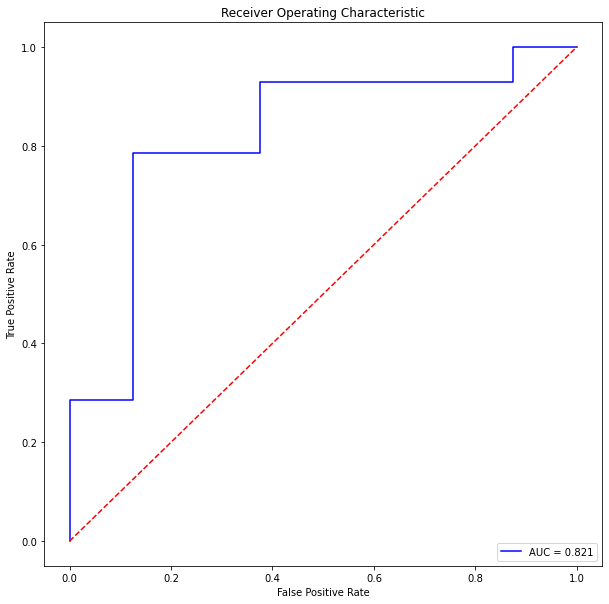

In [17]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

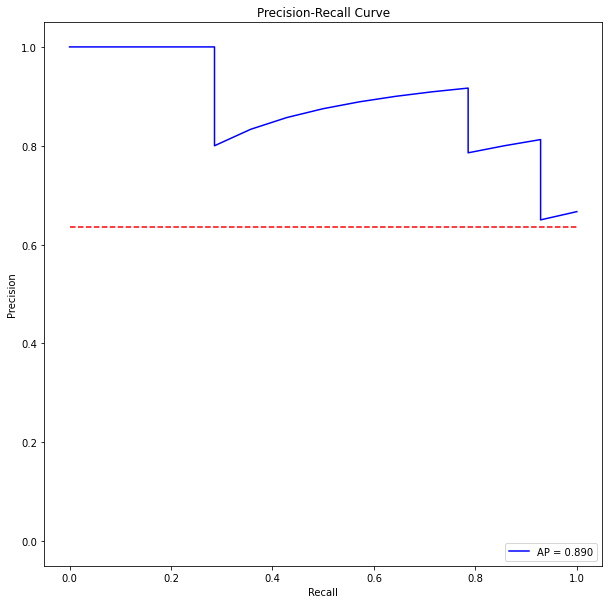

In [18]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

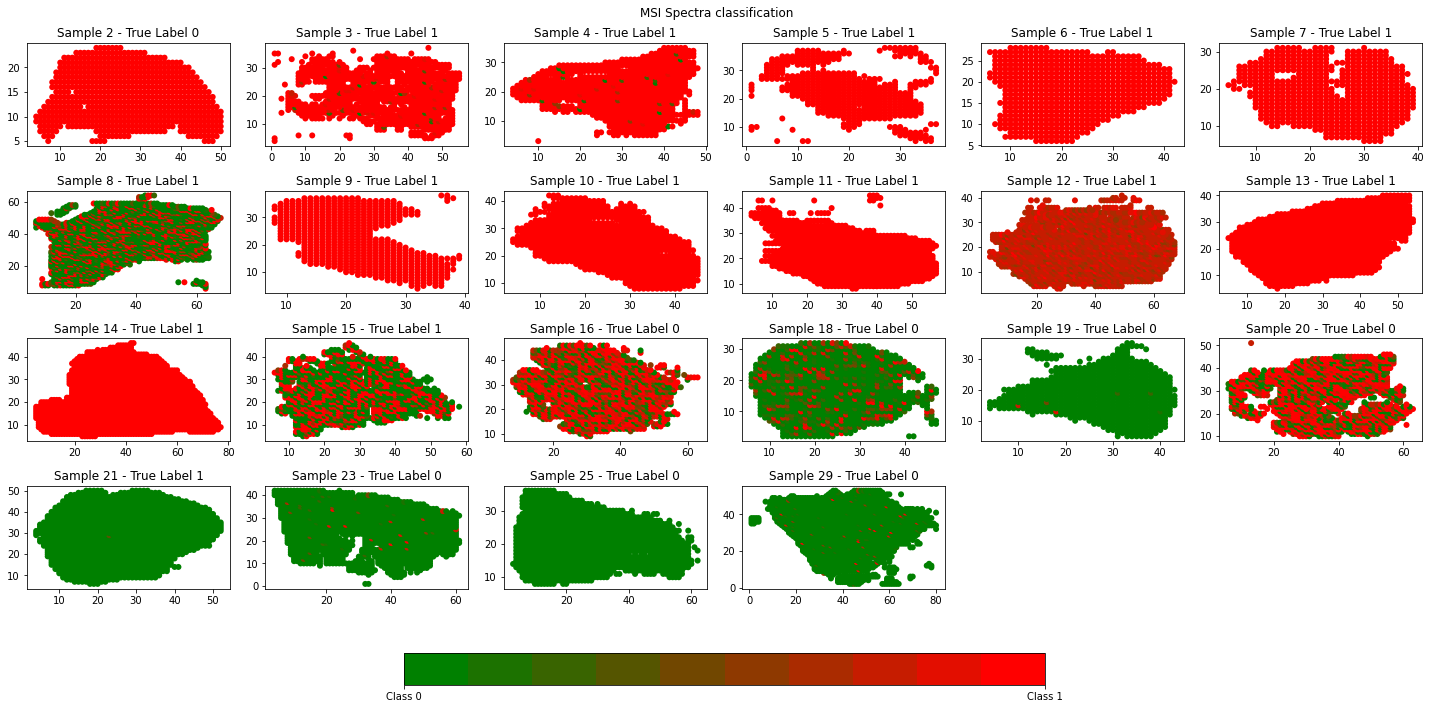

In [19]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & is_tissue],
                  y_coordinates[(sample_numbers == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Leave one sample out classification evaluation - non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [20]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [01:32<00:00,  4.21s/it]


Next, let's get some statistics about each left out sample predictions:

In [21]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.9999637604,1.0000000000,0.9999994040,0.9999989867,0.0000019076,0,1
1,3,0.9108913541,0.9999992847,0.9999575615,0.9994170070,0.0041246573,1,1
2,4,0.9999784231,1.0000000000,1.0000000000,0.9999998212,0.0000012463,1,1
3,5,0.9973619580,0.9999867678,0.9998430014,0.9997994304,0.0001679828,1,1
4,6,0.9999388456,0.9999979734,0.9999949932,0.9999926090,0.0000064953,1,1
5,7,0.9999998808,1.0000000000,1.0000000000,1.0000000000,0.0000000142,1,1
6,8,0.3089865446,1.0000000000,0.9999997616,0.9994670749,0.0156797916,1,1
7,9,0.9992068410,1.0000000000,0.9999990463,0.9999961257,0.0000244257,1,1
8,10,0.9991889596,1.0000000000,0.9999995232,0.9999980927,0.0000245496,1,1
9,11,0.9136140943,1.0000000000,0.9999997616,0.9999672771,0.0015461372,1,1


Next, let's evaluate the classification performance:

In [22]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.818
Balanced  Accuracy: 0.804
Precision: 0.857
Recall: 0.857
F1 score: 0.857


Next, let's plot the roc curve:

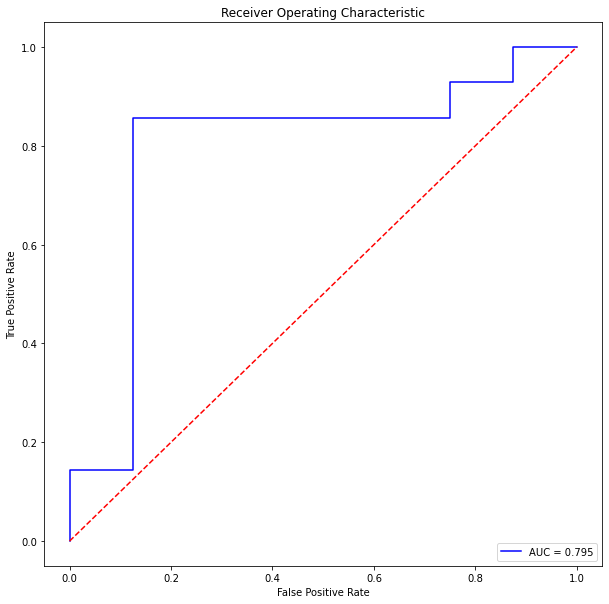

In [23]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

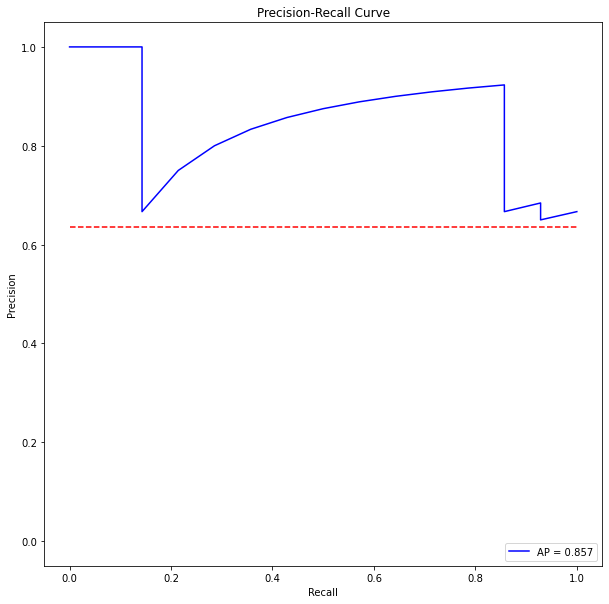

In [24]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

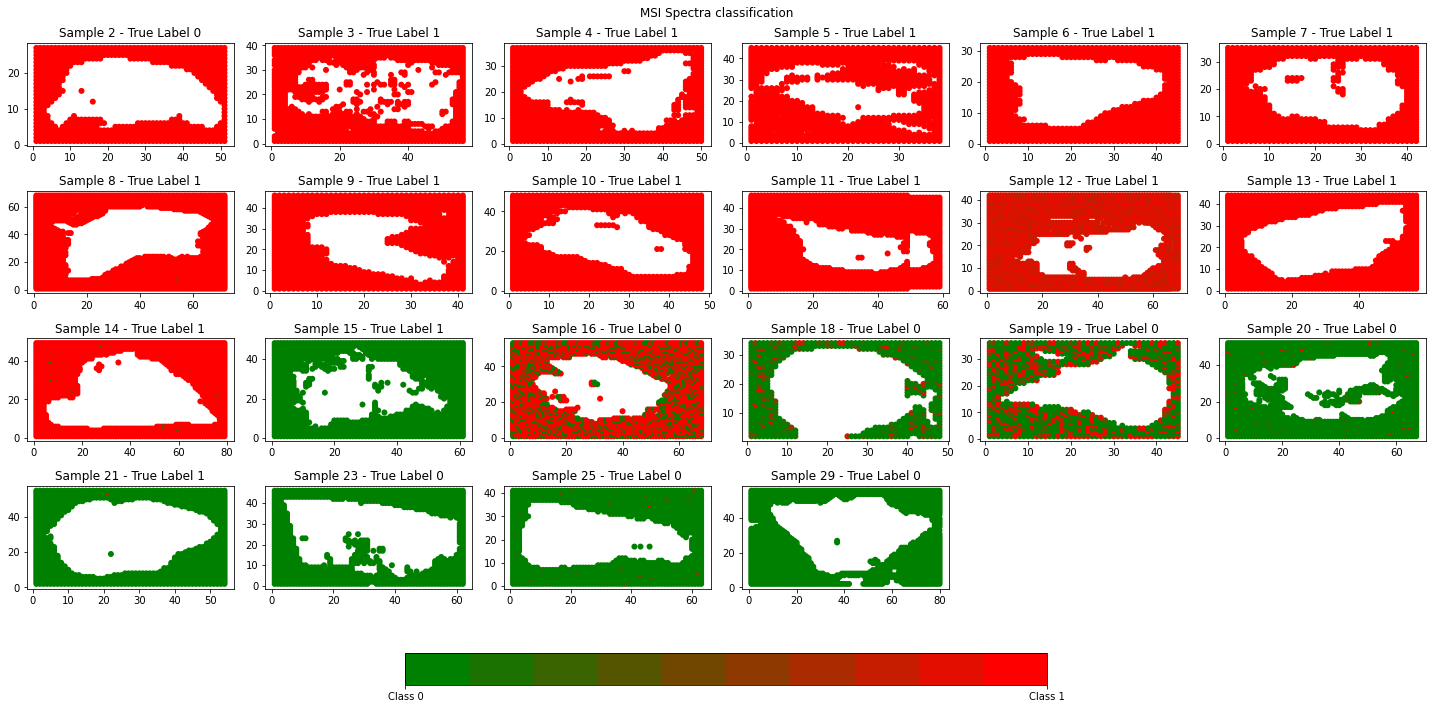

In [25]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & ~is_tissue],
                  y_coordinates[(sample_numbers == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [26]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()